**Requirements:**
- torch
- torchaudio
- torchvision
- ftfy
- regex
- tqdm
- opencv-python-headless
- git+https://github.com/openai/CLIP.git

In [1]:
import torch
import clip
from PIL import Image
import glob
import numpy as np
import os
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
import CLIP_for_FICE

# Interacting with original CLIP

In [2]:
# available CLIP models:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [3]:
model, preprocess = clip.load('ViT-B/32')

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(type(preprocess), preprocess)

<class 'torchvision.transforms.transforms.Compose'> Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x0000027AB841EF20>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)


In [5]:
# toeknizing a senmtece
temp = clip.tokenize('Hello World!!')
print(temp.device, temp.shape)

cpu torch.Size([1, 77])


loading some sample data of 8 images

In [6]:
original_imgs = []
img_tensors = []
captions = []
for filename in list(os.listdir('./Sample_Images')):
    img = Image.open(f'./Sample_Images/{filename}').convert('RGB')
    original_imgs.append(img)
    img_tensor = preprocess(img)
    img_tensors.append(img_tensor)
    captions.append(filename.split('.')[0])
print(captions)

['astronaut', 'boy_in_pool', 'Buildings', 'camera', 'car', 'cycle', 'horses', 'sunglasses']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..2.145897].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..2.145897].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5878845..2.145897].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..2.0179167].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..2.145897].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..2.145897].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7370893..2.

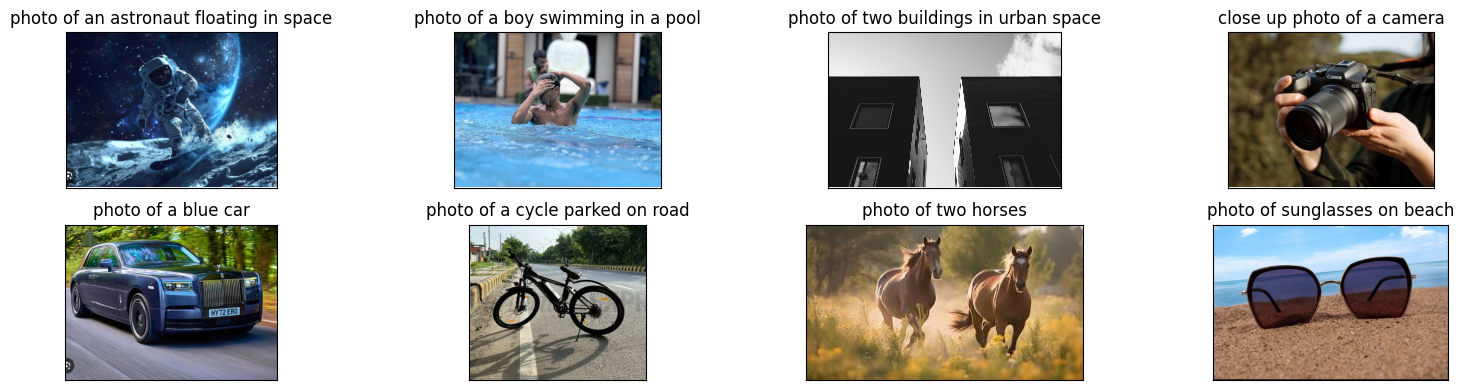

In [7]:
captions[0] = 'photo of an astronaut floating in space'
captions[1] = 'photo of a boy swimming in a pool'
captions[2] = 'photo of two buildings in urban space'
captions[3] = 'close up photo of a camera'
captions[4] = 'photo of a blue car'
captions[5] = 'photo of a cycle parked on road'
captions[6] = 'photo of two horses'
captions[7] = 'photo of sunglasses on beach'
plt.figure(figsize=(16,4))
for idx, img in enumerate(original_imgs):
    warnings.filterwarnings('ignore')
    plt.subplot(2,4,idx+1)
    plt.imshow(img_tensors[idx].cpu().permute(1,2,0))
    plt.imshow(original_imgs[idx])
    plt.xticks([])
    plt.yticks([])
    plt.title(captions[idx])
plt.tight_layout()

img_input = torch.Tensor(np.stack(img_tensors)).cuda()
txt_tokens = clip.tokenize(['This is a' + txt for txt in captions]).cuda()

In [8]:
print(img_input.shape, txt_tokens.shape)
with torch.no_grad():
    img_features = model.encode_image(img_input).float()
    txt_features = model.encode_text(txt_tokens).float()
print(img_features.shape, txt_features.shape)
temp = torch.mul(img_features, txt_features)
print(temp.size())
temp = temp.sum(dim=-1)
temp.size()
temp = temp.mean()
print(temp)

torch.Size([8, 3, 224, 224]) torch.Size([8, 77])
torch.Size([8, 512]) torch.Size([8, 512])
torch.Size([8, 512])
tensor(29.8118, device='cuda:0')


normalizing and finding similarity scores

In [9]:
img_features /= img_features.norm(dim=-1, keepdim=True)
txt_features /= txt_features.norm(dim=-1, keepdim=True)
similarity_score = txt_features.cpu().numpy() @ img_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text and image features')

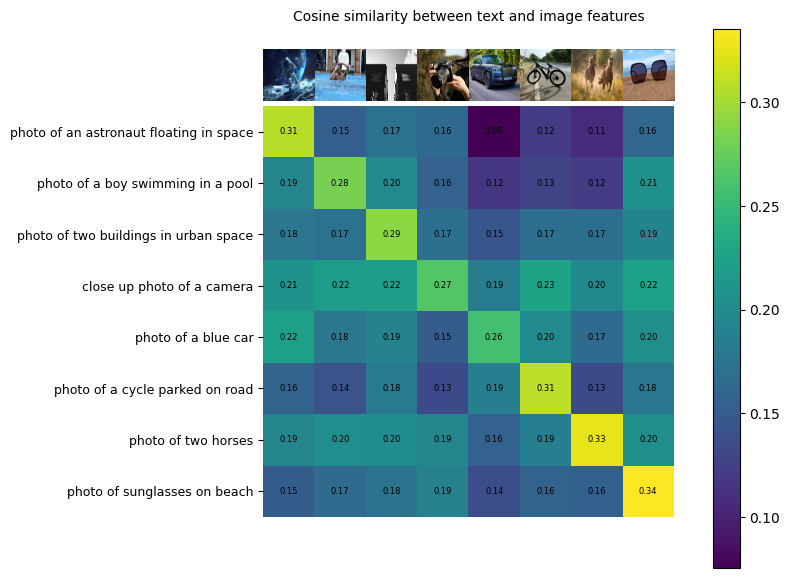

In [10]:
# sns.heatmap(similarity_score, annot=True, yticklabels=captions, xticklabels=original_imgs)
count = len(captions)
plt.figure(figsize=(10,7))
plt.imshow(similarity_score)
plt.colorbar()
plt.yticks(range(count), captions, fontsize=9)
plt.xticks([])
for i, image in enumerate(original_imgs):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin='lower')
for x in range(similarity_score.shape[1]):
  for y in range(similarity_score.shape[0]):
    plt.text(x,y, f"{similarity_score[y, x]:.2f}", ha="center", va="center", size=6)

for side in ["left", "top", "right", "bottom"]:
    plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count-0.5])
plt.ylim([count+0.5, -2])
plt.title("Cosine similarity between text and image features", size=10)

finding most similar label of image with the classe of cifar100

In [11]:
string = "aquarium fish, flatfish, ray, shark, trout orchids, poppies, roses, sunflowers, tulips bottles, bowls, cans, cups, plates apples, mushrooms, oranges, pears, sweet peppers clock, computer keyboard, lamp, telephone, television bed, chair, couch, table, wardrobe bee, beetle, butterfly, caterpillar, cockroach bear, leopard, lion, tiger, wolf bridge, castle, house, road, skyscraper cloud, forest, mountain, plain, sea camel, cattle, chimpanzee, elephant, kangaroo fox, porcupine, possum, raccoon, skunk crab, lobster, snail, spider, worm baby, boy, girl, man, woman crocodile, dinosaur, lizard, snake, turtle hamster, mouse, rabbit, shrew, squirrel maple, oak, palm, pine, willow bicycle, bus, motorcycle, pickup truck, train lawn-mower, rocket, streetcar, tank, tractor"
classes = list(string.replace(",", " ").replace("  ", " ").split(" "))
tokens = ['This is a photo of ' + class_ for class_ in classes]

txt_features = model.encode_text(clip.tokenize(tokens).cuda()).float()
print(txt_features.shape)
txt_features /= txt_features.norm(dim=-1, keepdim=True)
# with torch.no_grad():
similarity_score = (100.0 * img_features @ txt_features.T).softmax(dim=-1)
print(similarity_score.shape)

top_scores, top_labels = similarity_score.cpu().topk(5, dim = -1)
print(top_scores)
print(top_labels)

torch.Size([99, 512])
torch.Size([8, 99])
tensor([[0.1325, 0.0741, 0.0524, 0.0506, 0.0336],
        [0.2215, 0.1014, 0.0454, 0.0319, 0.0297],
        [0.2939, 0.2272, 0.0708, 0.0437, 0.0352],
        [0.0711, 0.0658, 0.0564, 0.0561, 0.0422],
        [0.0847, 0.0763, 0.0701, 0.0655, 0.0652],
        [0.9343, 0.0271, 0.0242, 0.0029, 0.0014],
        [0.3491, 0.1189, 0.0725, 0.0411, 0.0327],
        [0.1903, 0.1155, 0.0861, 0.0459, 0.0398]], grad_fn=<TopkBackward0>)
tensor([[71, 51, 95, 42, 27],
        [71, 69, 52,  4, 41],
        [47, 45, 32, 51, 27],
        [58, 74, 57, 76, 66],
        [89, 91, 40, 45, 28],
        [88, 46, 90, 91, 69],
        [54, 53, 20, 49, 51],
        [52, 51, 85, 31,  3]])


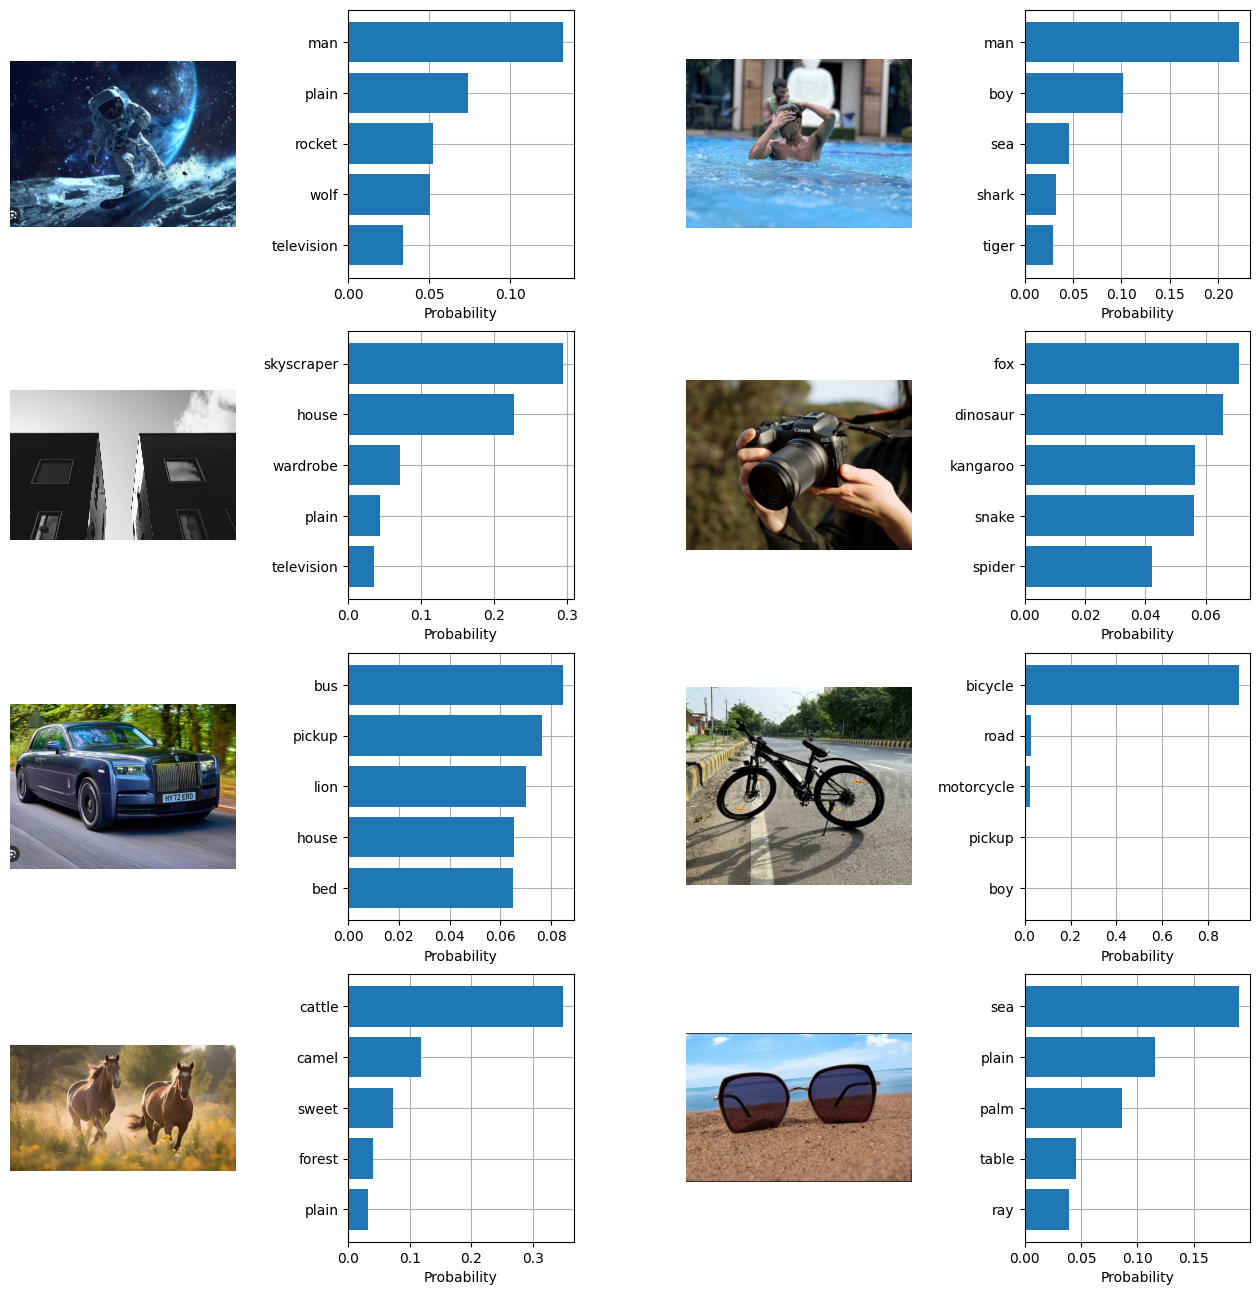

In [12]:
plt.figure(figsize=(16,16))

for i, image in enumerate(original_imgs):
    plt.subplot(4,4,2*i+1)
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(4,4,2*i+2)
    y = np.arange(top_scores.shape[-1])
    plt.grid()
    plt.barh(y, top_scores[i].detach())
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [classes[index] for index in top_labels[i].numpy()])
    plt.xlabel('Probability')

plt.subplots_adjust(wspace=0.5)
plt.show()

# Using our custom defined CLIP module

In [13]:
txt_features = CLIP_for_FICE.CLIP_encode_text(['This is a' + txt for txt in captions])

In [14]:
txt_features.shape

torch.Size([8, 1024])

In [15]:
img_features = CLIP_for_FICE.CLIP_encode_image(original_imgs, raw_image=True)

In [16]:
img_features.shape

torch.Size([8, 1024])

In [17]:
loss = CLIP_for_FICE.CLIP_loss(['This is a' + txt for txt in captions], original_imgs, True)
loss

tensor(54.8936, device='cuda:0', grad_fn=<SumBackward0>)

In [18]:
loss = CLIP_for_FICE.CLIP_loss(['This is a' + txt for txt in captions], img_input, False)
loss

tensor(56.8917, device='cuda:0', grad_fn=<SumBackward0>)

In [19]:
similarity = img_features @ txt_features.T
print(similarity.shape)

torch.Size([8, 8])
